# Data preprocessing

In [2]:
import plotting
import util
import preprocessing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
from tqdm import tqdm

from skimage import filters, segmentation, feature, measure, morphology
from skimage.exposure import equalize_adapthist, rescale_intensity
from skimage.color import label2rgb
from skimage.io import imread, imsave

import scipy.ndimage as ndi

## Import input and output data

In [3]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


### Original stack labels

In [5]:
labels = np.zeros(output_data.shape, dtype=np.uint8)
for frame, output_img in tqdm(enumerate(output_data), total=output_data.shape[0]):
  labels[frame] = preprocessing.distance_watershed(output_img*segmentation.clear_border(output_img>0), sigma=0)
util.save_h5(labels, data_path, 'labels')

100%|███████████████████████████████████████████████████████| 37000/37000 [02:01<00:00, 303.98it/s]


Saving H:/Santi/Data/labels.h5
Done.


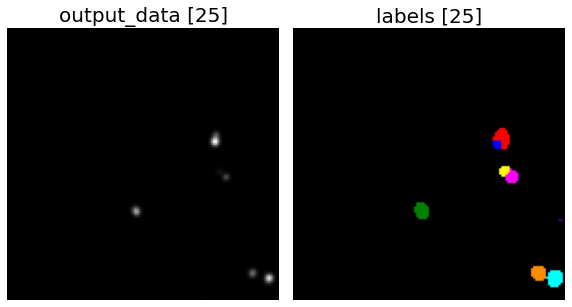

In [11]:
frame = 25
plotting.plot_comparison(output_data[frame], label2rgb(labels[frame], bg_label=0), labels=['output_data', 'labels'], frame=frame)
plt.show()

## Input data histogram equalization

In [ ]:
#clip_limit = 0.1
#proc_input_data = np.array([equalize_adapthist(input_img, clip_limit=clip_limit) for input_img in tqdm(input_data, total=input_data.shape[0])])
#bg_max_intensity = proc_input_data[input_data==0].max()
#proc_input_data = (255*np.clip((proc_input_data-bg_max_intensity)/(proc_input_data.max()-bg_max_intensity), 0, 1)).astype(input_data.dtype)

proc_input_data = util.load_h5(data_path, 'MitoProc')
print('Equalized inputs:', proc_input_data.shape)

In [ ]:
frame = 34136
plotting.plot_comparison(input_data[frame], proc_input_data[frame], cmap='viridis', labels=['input_data', 'proc_input_data'], frame=frame)
plt.show()

## GT preprocessing
### Filter events by mean probability of division and replace each fission by a gaussian disk
Original GT prepared by Dora Mahecic includes all of the events that might be fissions:

H:/Santi/Figures/ground_truth_t00025.pdf


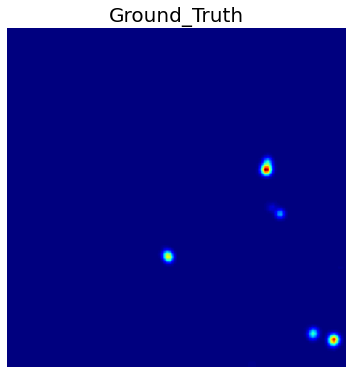

In [3]:
item_id = 25#34136#26286#np.random.randint(0, len(proc_output_data))
img = output_data[item_id]
cmap = 'jet'
title = 'ground_truth'
filename = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title(title.title(), size=20)
ax.imshow(img, cmap=cmap)
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()
#plt.savefig(filename)

To filter this GT:

1. Remove events that are in contact with the border of the image.
2. Calculate the Distance Map by measuring the distance from local maxima to the border of the object

H:/Santi/Figures/distance_map_t00025.pdf


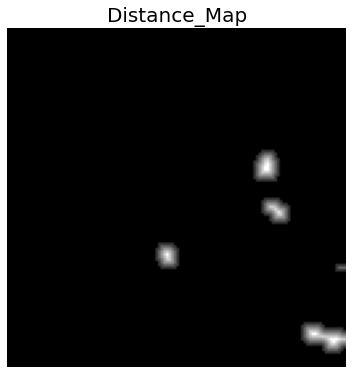

In [4]:
sigma = 2
mask = segmentation.clear_border(img>0)
img_proc = img*mask
distance = ndi.distance_transform_edt(filters.gaussian(img_proc, sigma/10))

cmap = 'gray'
title = 'distance_map'
filename = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title(title.title(), size=20)
ax.imshow(distance, cmap=cmap)
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()
#plt.savefig(filename)

3. Segment fissions by using Distance Map as the input intensity image and local maxima as markers to implement the Watershed algorithm

In [127]:
ar = np.array([[1, 2], [10, 20], [1, 20]])

ar[(np.array([1, 2]), np.array([0, 1]))] = np.array([0.4, 10.5])

ar

array([[ 1,  2],
       [ 0, 20],
       [ 1, 10]])

H:/Santi/Figures/watershed_t00025.pdf


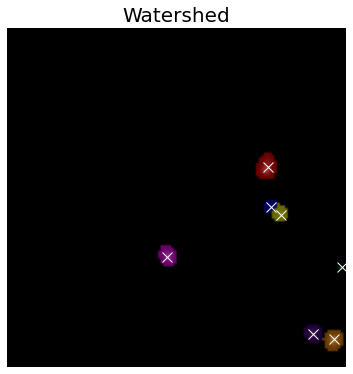

In [5]:
labels = preprocessing.distance_watershed(img_proc, sigma=sigma/10)

rp = measure.regionprops_table(labels, intensity_image=img_proc, properties=['weighted_centroid'])
centroids = np.array([rp['weighted_centroid-0'], rp['weighted_centroid-1']]).round().astype(int)


title = 'watershed'
filename = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title(title.title(), size=20)
ax.imshow(label2rgb(labels, image=img_proc, alpha=0.4, bg_label=0))

ax.plot(centroids[1], centroids[0], 'x', markersize=10, color='white')

ax.axis('off')
plt.tight_layout(pad=0)
plt.show()
#plt.savefig(filename)

4. Calculate mean intensity per fission and remove those below a given **threshold**.
5. Gaussian dilation (**sigma** is an input) of mask generated from fission centroids 
6. Choose a **number of sigmas** to cut the gaussian dilation at a radius equal to round(dilation_nb_sigmas*sigma).
7. Rescale intensity so there is a smooth transition between the background and fission intensities.

In [5]:
#Estimate thresholds from mean and std intensity 
#mean_intensity = output_data[output_data!=0].mean()
#std_intensity = output_data[output_data!=0].std()
#weigth = np.array([-0.5, -0.25, -0.1, 0, 0.1, 0.5, 1])

#threshold = mean_intensity + weigth*std_intensity
#util.save_pkl(threshold, data_path, 'mean_intensity_threshold')

threshold = util.load_pkl(data_path, 'mean_intensity_threshold')


Loading H:/Santi/Data/mean_intensity_threshold


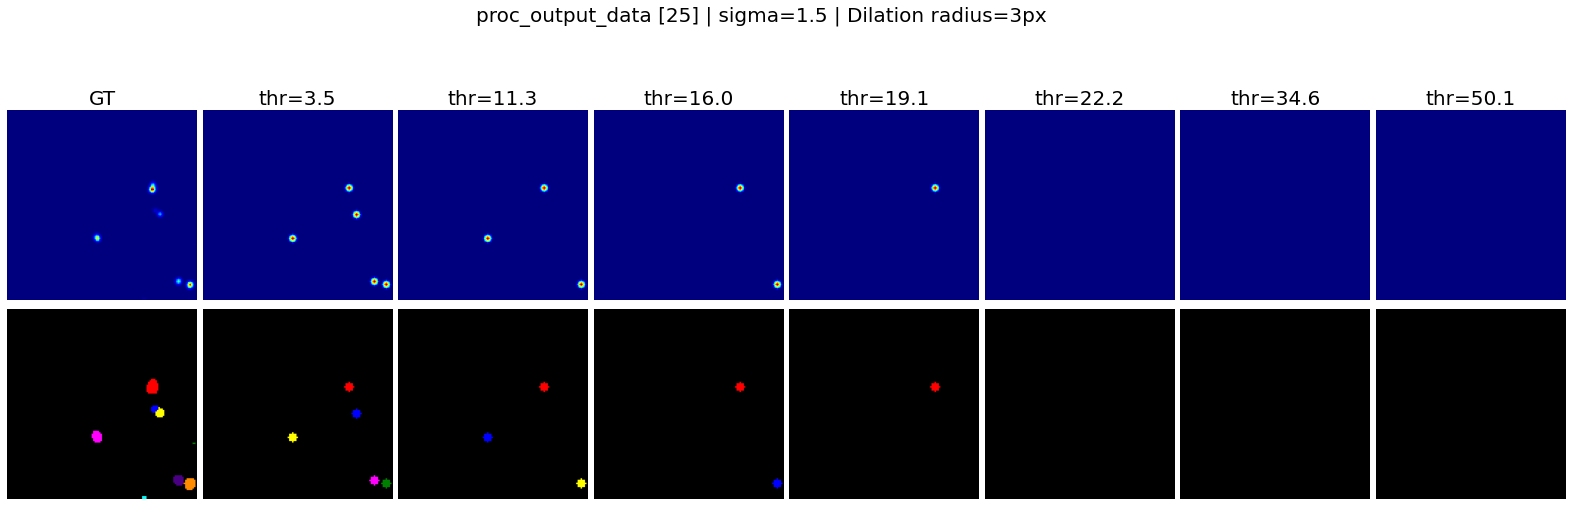

In [11]:
sigma = 1.5
dilation_nb_sigmas = 2

nb_cols = len(threshold)+1
title_size = 20
cmap = 'jet'
frame = 25
labels = preprocessing.distance_watershed(output_data[frame], sigma=sigma/10)

fig, axes = plt.subplots(2, nb_cols, figsize=(nb_cols*3.5, 2*4))
for thr, ax_img, ax_labels in zip(threshold, axes[0, 1:], axes[1, 1:]):
  img_proc, fission_props = preprocessing.prepareProc(output_data[frame], sigma=sigma, dilation_nb_sigmas=dilation_nb_sigmas, threshold=thr)
  new_labels = preprocessing.segmentFissions(img_proc, fission_props, 0)
  ax_img.set_title('thr=%.1f'%thr, size=title_size)
  ax_img.imshow(img_proc, cmap=cmap)
  ax_img.axis('off')
  
  ax_labels.imshow(label2rgb(new_labels, bg_label=0)) 
  ax_labels.axis('off')

axes[1, 0].imshow(label2rgb(labels, bg_label=0))
axes[0, 0].set_title('GT', size=title_size)
axes[0, 0].imshow(output_data[frame], cmap=cmap)
axes[0, 0].axis('off')
axes[1, 0].axis('off')
  
fig.suptitle('proc_output_data [%i] | sigma=%.1f | Dilation radius=%ipx'%(frame, sigma, round(dilation_nb_sigmas*sigma)), size=title_size)
fig.subplots_adjust(wspace=0.01, hspace=0.05, top=0.8)
plt.show()

#### How to choose the sigma of the gaussian dilation

##### Preprocess GT using different minimum spot sizes and mean intensity thresholds

In [51]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 
optimal_sigma_data_path = data_path + 'optimal_sigma_data/'
sigmas = np.array([1.5, 2, 2.5, 3])
dilation_nb_sigmas = 2

threshold = util.load_pkl(data_path, 'mean_intensity_threshold')

#Choose 1000 random images to reduce the amount of data used to estimate optimal sigma
indices = np.sort(np.random.choice(output_data.shape[0], 1000, replace=False))
util.save_pkl(indices, optimal_sigma_data_path, 'indices')

optimal_sigma_output_data = output_data[indices]
for s in sigmas:
  for thr in threshold:
    print('\nSigma: %.1f | Threshold: %.1f'%(s, thr))
    proc_output_data, fission_props = preprocessing.prepareStack(optimal_sigma_output_data, sigma=s, 
                                                                 dilation_nb_sigmas=dilation_nb_sigmas, threshold=thr)
    proc_labels = preprocessing.segmentFissionsStack(proc_output_data, fission_props)
    util.save_h5(proc_output_data, optimal_sigma_data_path, 'WatProc_s%.1f_t%.1f'%(s, thr))
    util.save_h5(proc_labels, optimal_sigma_data_path, 'proc_labels_s%.1f_t%.1f'%(s, thr))
    util.save_pkl(fission_props, optimal_sigma_data_path, 'fission_props_s%.1f_t%.1f'%(s, thr))
    
util.save_pkl(sigmas, data_path, 'sigmas')


Loading H:/Santi/Data/mean_intensity_threshold

Saving H:/Santi/Data/optimal_sigma_data/indices
Done.

Sigma: 1.5 | Threshold: 3.5


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 864.85it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s1.5_t3.5.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s1.5_t3.5.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t3.5
Done.

Sigma: 1.5 | Threshold: 11.3


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1191.97it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s1.5_t11.3.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s1.5_t11.3.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t11.3
Done.

Sigma: 1.5 | Threshold: 16.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1511.77it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s1.5_t16.0.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s1.5_t16.0.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t16.0
Done.

Sigma: 1.5 | Threshold: 19.1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1714.08it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s1.5_t19.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s1.5_t19.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t19.1
Done.

Sigma: 1.5 | Threshold: 22.2


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1930.08it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s1.5_t22.2.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s1.5_t22.2.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t22.2
Done.

Sigma: 1.5 | Threshold: 34.6


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4541.84it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s1.5_t34.6.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s1.5_t34.6.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t34.6
Done.

Sigma: 1.5 | Threshold: 50.1


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 18847.67it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s1.5_t50.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s1.5_t50.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t50.1
Done.

Sigma: 2.0 | Threshold: 3.5


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 796.90it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.0_t3.5.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.0_t3.5.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t3.5
Done.

Sigma: 2.0 | Threshold: 11.3


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1130.37it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.0_t11.3.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.0_t11.3.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t11.3
Done.

Sigma: 2.0 | Threshold: 16.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1413.38it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.0_t16.0.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.0_t16.0.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t16.0
Done.

Sigma: 2.0 | Threshold: 19.1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1729.82it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.0_t19.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.0_t19.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t19.1
Done.

Sigma: 2.0 | Threshold: 22.2


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1921.63it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.0_t22.2.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.0_t22.2.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t22.2
Done.

Sigma: 2.0 | Threshold: 34.6


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4535.23it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.0_t34.6.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.0_t34.6.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t34.6
Done.

Sigma: 2.0 | Threshold: 50.1


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 21330.30it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.0_t50.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.0_t50.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t50.1
Done.

Sigma: 2.5 | Threshold: 3.5


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 780.07it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.5_t3.5.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.5_t3.5.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.5_t3.5
Done.

Sigma: 2.5 | Threshold: 11.3


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1131.69it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.5_t11.3.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.5_t11.3.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.5_t11.3
Done.

Sigma: 2.5 | Threshold: 16.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1471.66it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.5_t16.0.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.5_t16.0.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.5_t16.0
Done.

Sigma: 2.5 | Threshold: 19.1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1739.84it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.5_t19.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.5_t19.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.5_t19.1
Done.

Sigma: 2.5 | Threshold: 22.2


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1989.14it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.5_t22.2.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.5_t22.2.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.5_t22.2
Done.

Sigma: 2.5 | Threshold: 34.6


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4709.30it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.5_t34.6.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.5_t34.6.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.5_t34.6
Done.

Sigma: 2.5 | Threshold: 50.1


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 18496.42it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s2.5_t50.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s2.5_t50.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s2.5_t50.1
Done.

Sigma: 3.0 | Threshold: 3.5


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 786.06it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s3.0_t3.5.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s3.0_t3.5.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s3.0_t3.5
Done.

Sigma: 3.0 | Threshold: 11.3


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1142.54it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s3.0_t11.3.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s3.0_t11.3.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s3.0_t11.3
Done.

Sigma: 3.0 | Threshold: 16.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1510.24it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s3.0_t16.0.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s3.0_t16.0.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s3.0_t16.0
Done.

Sigma: 3.0 | Threshold: 19.1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1718.38it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s3.0_t19.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s3.0_t19.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s3.0_t19.1
Done.

Sigma: 3.0 | Threshold: 22.2


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1974.98it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s3.0_t22.2.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s3.0_t22.2.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s3.0_t22.2
Done.

Sigma: 3.0 | Threshold: 34.6


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4778.74it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s3.0_t34.6.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s3.0_t34.6.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s3.0_t34.6
Done.

Sigma: 3.0 | Threshold: 50.1


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 19217.01it/s]



Saving H:/Santi/Data/optimal_sigma_data/WatProc_s3.0_t50.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/proc_labels_s3.0_t50.1.h5
Done.

Saving H:/Santi/Data/optimal_sigma_data/fission_props_s3.0_t50.1
Done.

Saving H:/Santi/Data/sigmas
Done.


##### How to choose the optimal sigma for gaussian dilation given a mean intensity threshold

In this section, we compare the mean diameter of all fissions in the GT to the one calculated from the different preprocessed outputs.

1) Load sigmas used  and thresholds used in the previous stage of the preprocessing

In [2]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 
optimal_sigma_data_path = data_path + 'optimal_sigma_data/'

sigmas = util.load_pkl(data_path, 'sigmas')
threshold = util.load_pkl(data_path, 'mean_intensity_threshold')
nb_sigmas = sigmas.shape[0]
nb_thresholds = threshold.shape[0]
indices = util.load_pkl(optimal_sigma_data_path, 'indices')

fission_props_filename, proc_output_data_filename, proc_labels_filename = [], [], []
for s in sigmas:
  for t in threshold:
    fission_props_filename += ['fission_props_s%.1f_t%.1f'%(s, t)]
    proc_output_data_filename += ['WatProc_s%.1f_t%.1f'%(s, t)]
    proc_labels_filename += ['proc_labels_s%.1f_t%.1f'%(s, t)]
    
fission_props = util.load_pkl(optimal_sigma_data_path, fission_props_filename, as_type=np.ndarray)
proc_output_data = util.load_h5(optimal_sigma_data_path, proc_output_data_filename)
proc_labels = util.load_h5(optimal_sigma_data_path, proc_labels_filename)


Loading H:/Santi/Data/sigmas

Loading H:/Santi/Data/mean_intensity_threshold

Loading H:/Santi/Data/optimal_sigma_data/indices

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t3.5

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t11.3

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t16.0

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t19.1

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t22.2

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t34.6

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s1.5_t50.1

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t3.5

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t11.3

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t16.0

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t19.1

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t22.2

Loading H:/Santi/Data/optimal_sigma_data/fission_props_s2.0_t34.6

Lo

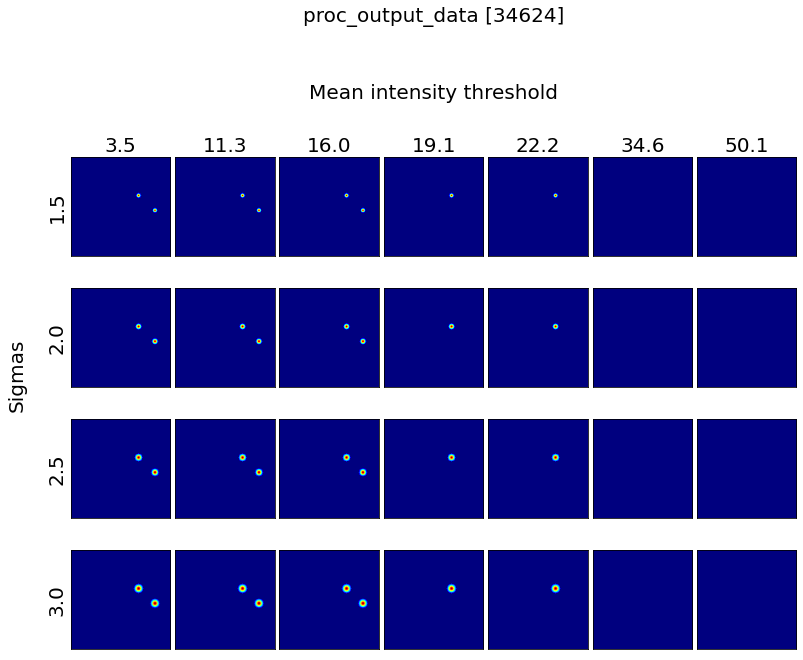

In [5]:
item_id = 926
nb_sigmas_threshold_ratio = 0.8*nb_sigmas/nb_thresholds
space = 0.05
width = 3
title_size = 20
cmap = 'jet'

fig, axes = plt.subplots(nb_sigmas, nb_thresholds, figsize=(width*nb_sigmas*(1+space), width*nb_thresholds*(nb_sigmas_threshold_ratio+space)))
fig.suptitle('proc_output_data [%i]'%indices[item_id], size=title_size)

for s_id in range(nb_sigmas):
  for t_id in range(nb_thresholds):
    axes[s_id, t_id].imshow(proc_output_data[t_id+s_id*nb_thresholds][item_id], cmap=cmap, aspect='equal')
    axes[s_id, t_id].set(xticks=[], yticks=[])
    
for t_id in range(nb_thresholds):
  axes[0, t_id].set_title('%.1f'%threshold[t_id], size=title_size)
  
for s_id in range(nb_sigmas):
  axes[s_id, 0].set_ylabel('%.1f'%sigmas[s_id], size=title_size)
  
fig.text(0.5, 0.86, 'Mean intensity threshold', fontsize=title_size, ha='center')
fig.text(0.03, 0.5, 'Sigmas', fontsize=title_size, va='center', rotation=90)
fig.subplots_adjust(hspace=space, wspace=space, top=0.8, left=0.1)
plt.show()

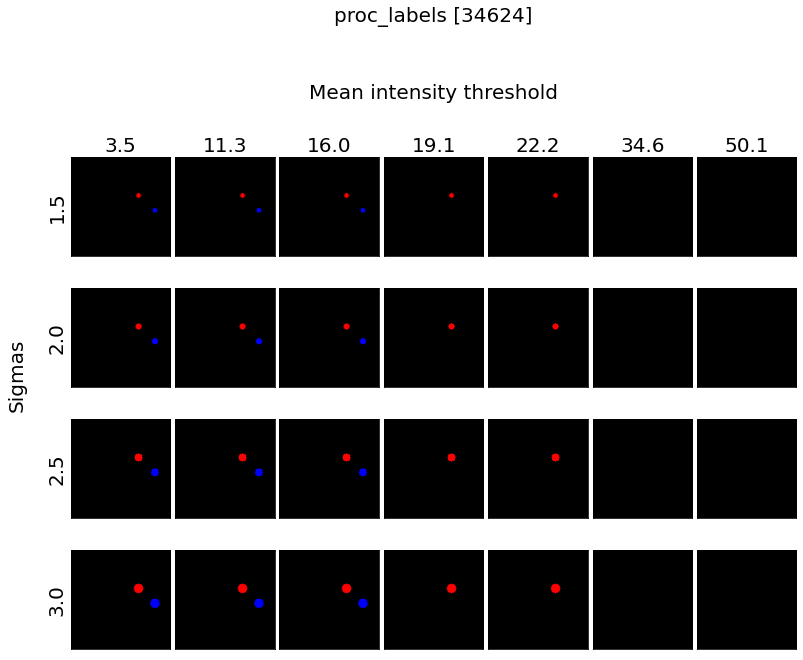

In [6]:
nb_sigmas_threshold_ratio = 0.8*nb_sigmas/nb_thresholds
space = 0.05
width = 3
title_size = 20
cmap = 'jet'

fig, axes = plt.subplots(nb_sigmas, nb_thresholds, figsize=(width*nb_sigmas*(1+space), width*nb_thresholds*(nb_sigmas_threshold_ratio+space)))
fig.suptitle('proc_labels [%i]'%indices[item_id], size=title_size)

for s_id in range(nb_sigmas):
  for t_id in range(nb_thresholds):
    axes[s_id, t_id].imshow(label2rgb(proc_labels[t_id+s_id*nb_thresholds][item_id], bg_label=0))
    axes[s_id, t_id].set(xticks=[], yticks=[])
    
for t_id in range(nb_thresholds):
  axes[0, t_id].set_title('%.1f'%threshold[t_id], size=title_size)
  
for s_id in range(nb_sigmas):
  axes[s_id, 0].set_ylabel('%.1f'%sigmas[s_id], size=title_size)
  
fig.text(0.5, 0.86, 'Mean intensity threshold', fontsize=title_size, ha='center')
fig.text(0.03, 0.5, 'Sigmas', fontsize=title_size, va='center', rotation=90)
fig.subplots_adjust(hspace=space, wspace=space, top=0.8, left=0.1)
plt.show()

2) Calculate properties of outputs (GT was already analyzed before. See files 'fission_props_*')

In [9]:
proc_fission_props = []
print('Getting properties...')
for i in range(proc_output_data.shape[0]):
    print('\n'+proc_labels_filename[i])
    props = preprocessing.analyzeFissionsStack(proc_labels[i], proc_output_data[i])
    proc_fission_props += [props] 
    util.save_pkl(props, optimal_sigma_data_path, 'proc_fission_props_s%s'%proc_labels_filename[i].split('_s')[-1],)

Getting properties...

proc_labels_s1.5_t3.5


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3532.27it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t3.5
Done.

proc_labels_s1.5_t11.3


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5258.45it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t11.3
Done.

proc_labels_s1.5_t16.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6751.94it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t16.0
Done.

proc_labels_s1.5_t19.1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7401.70it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t19.1
Done.

proc_labels_s1.5_t22.2


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8394.95it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t22.2
Done.

proc_labels_s1.5_t34.6


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 15606.02it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t34.6
Done.

proc_labels_s1.5_t50.1


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 26994.54it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t50.1
Done.

proc_labels_s2.0_t3.5


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3518.33it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t3.5
Done.

proc_labels_s2.0_t11.3


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5176.74it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t11.3
Done.

proc_labels_s2.0_t16.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6705.17it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t16.0
Done.

proc_labels_s2.0_t19.1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7805.01it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t19.1
Done.

proc_labels_s2.0_t22.2


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8466.94it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t22.2
Done.

proc_labels_s2.0_t34.6


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 15605.26it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t34.6
Done.

proc_labels_s2.0_t50.1


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 30246.00it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t50.1
Done.

proc_labels_s2.5_t3.5


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3530.78it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.5_t3.5
Done.

proc_labels_s2.5_t11.3


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5071.67it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.5_t11.3
Done.

proc_labels_s2.5_t16.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6707.63it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.5_t16.0
Done.

proc_labels_s2.5_t19.1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7744.33it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.5_t19.1
Done.

proc_labels_s2.5_t22.2


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8397.66it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.5_t22.2
Done.

proc_labels_s2.5_t34.6


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 15366.34it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.5_t34.6
Done.

proc_labels_s2.5_t50.1


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 23221.83it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.5_t50.1
Done.

proc_labels_s3.0_t3.5


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3457.34it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s3.0_t3.5
Done.

proc_labels_s3.0_t11.3


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4922.17it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s3.0_t11.3
Done.

proc_labels_s3.0_t16.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6661.75it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s3.0_t16.0
Done.

proc_labels_s3.0_t19.1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6890.62it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s3.0_t19.1
Done.

proc_labels_s3.0_t22.2


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8325.00it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s3.0_t22.2
Done.

proc_labels_s3.0_t34.6


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 15612.58it/s]



Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s3.0_t34.6
Done.

proc_labels_s3.0_t50.1


100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 32227.44it/s]


Saving H:/Santi/Data/optimal_sigma_data/proc_fission_props_s3.0_t50.1
Done.


In [10]:
#Loading processed statistics
proc_fission_props_filename = []

for s in sigmas:
  for t in threshold:
    proc_fission_props_filename += ['proc_fission_props_s%.1f_t%.1f'%(s, t)]
    
proc_fission_props = util.load_pkl(optimal_sigma_data_path, proc_fission_props_filename, as_type=np.ndarray)


Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t3.5

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t11.3

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t16.0

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t19.1

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t22.2

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t34.6

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s1.5_t50.1

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t3.5

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t11.3

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t16.0

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t19.1

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t22.2

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_t34.6

Loading H:/Santi/Data/optimal_sigma_data/proc_fission_props_s2.0_

In [11]:
nb_img = proc_output_data.shape[1]
diameter = []
proc_diameter = []

print('Calculating mean diameter')
for s_id in range(nb_sigmas):
  for t_id in range(nb_thresholds):
    print('s=%.1f | t=%.1f'%(sigmas[s_id], threshold[t_id]))
    i = t_id+s_id*nb_thresholds #Index corresponding to sigma=sigmas[s_id], thr=threshold[t_id]
    diameter += [[]]
    proc_diameter += [[]]
    for frame in tqdm(range(nb_img), total=nb_img):
      if len(fission_props[i][frame])>0:
        diameter[-1] += list(fission_props[i][frame]['equivalent_diameter'])
        proc_diameter[-1] += list(proc_fission_props[i][frame]['equivalent_diameter'])

Calculating mean diameter
s=1.5 | t=3.5


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 249334.44it/s]


s=1.5 | t=11.3


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 329611.32it/s]


s=1.5 | t=16.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 332590.91it/s]


s=1.5 | t=19.1


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 498965.50it/s]


s=1.5 | t=22.2


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 499203.05it/s]


s=1.5 | t=34.6


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 498668.89it/s]


s=1.5 | t=50.1


100%|█████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1003902.35it/s]


s=2.0 | t=3.5


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 249260.36it/s]


s=2.0 | t=11.3


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 332116.87it/s]


s=2.0 | t=16.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 497603.99it/s]


s=2.0 | t=19.1


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 335624.87it/s]


s=2.0 | t=22.2


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 339098.07it/s]


s=2.0 | t=34.6


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 506069.50it/s]


s=2.0 | t=50.1


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 981812.73it/s]


s=2.5 | t=3.5


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 249275.17it/s]


s=2.5 | t=11.3


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333145.67it/s]


s=2.5 | t=16.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 332485.45it/s]


s=2.5 | t=19.1


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 331696.64it/s]


s=2.5 | t=22.2


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 491193.82it/s]


s=2.5 | t=34.6


100%|█████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1003662.12it/s]


s=2.5 | t=50.1


100%|█████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1003422.01it/s]


s=3.0 | t=3.5


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 249201.12it/s]


s=3.0 | t=11.3


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 331749.11it/s]


s=3.0 | t=16.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 493679.85it/s]


s=3.0 | t=19.1


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 497603.99it/s]


s=3.0 | t=22.2


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 332986.98it/s]


s=3.0 | t=34.6


100%|█████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1016554.53it/s]


s=3.0 | t=50.1


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 979291.15it/s]


To compare GT with the processed outputs, we calculate the diameter ratio as

$$\text{Diameter ratio }(\sigma) = \dfrac{\langle d_{{PROC}}(\sigma) \rangle}{\langle d \rangle}$$

where $d$ and $d_{PROC}$ are the mean diameter of the GT and the processed output, respectively.

In [12]:
id_sort = np.array([[t_id+s_id*nb_thresholds for t_id in range(nb_thresholds)] for s_id in range(nb_sigmas)])
#d
mean_diameter = np.array([np.mean(d) for d in diameter])
#mean_diameter_err = np.array([np.mean(d)/len(d) for d in diameter])[id_sort]

#d_proc
mean_proc_diameter = np.array([np.mean(d_proc) for d_proc in proc_diameter])

#Diameter ratio
diam_ratio = (mean_proc_diameter/mean_diameter)[id_sort]
#diam_ratio_err = mean_proc_diameter*mean_diameter_err/(mean_diameter**2)

To determine the optimal sigma, we ask fission sites in the processed output to have the same mean diameter as in the GT. Therefore, the optimal sigma $\sigma_{opt}$ satisfies the condition

$$\text{Diameter ratio }(\sigma_{opt}) = 1 $$

In [13]:
a, b = np.polyfit(sigmas, diam_ratio, 1)

optimal_sigma = (1-b)/a
for t, s_opt in zip(threshold, optimal_sigma):
  print('t=%.1f | s_opt = %.4f'%(t, s_opt))
  
util.save_pkl(optimal_sigma, data_path, 'optimal_sigma')

t=3.5 | s_opt = 1.9324
t=11.3 | s_opt = 2.1030
t=16.0 | s_opt = 2.1785
t=19.1 | s_opt = 2.2196
t=22.2 | s_opt = 2.2480
t=34.6 | s_opt = 2.3923
t=50.1 | s_opt = 2.6630

Saving H:/Santi/Data/optimal_sigma
Done.


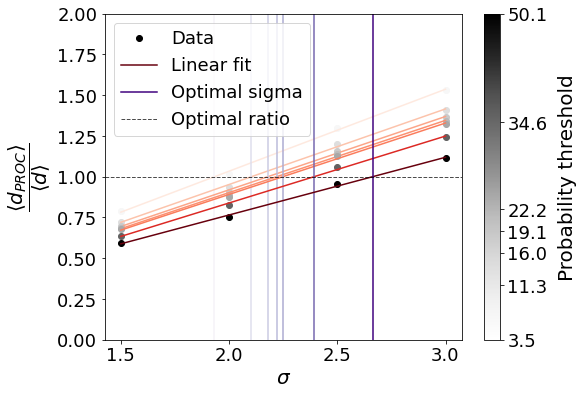

In [32]:
cmap_scatter = plt.cm.ScalarMappable(cmap='Greys', norm=Normalize(threshold.min(), threshold.max()))
cmap_linear_fit = plt.cm.ScalarMappable(cmap='Reds', norm=Normalize(threshold.min(), threshold.max()))
cmap_optimal_sigma = plt.cm.ScalarMappable(cmap='Purples', norm=Normalize(threshold.min(), threshold.max()))

t_step = (threshold[1]-threshold[0])/nb_thresholds

fig, ax = plt.subplots(figsize=(8, 6))

#Linear fit
for i in range(nb_thresholds):
  t_weight = threshold[i]/threshold[-1] #Defines color from cmap
  scatter = ax.plot(sigmas, diam_ratio[:, i], 'o', color=cmap_scatter.get_cmap()(t_weight))[0]
  line = ax.plot(sigmas, a[i]*sigmas+b[i], color=cmap_linear_fit.get_cmap()(t_weight))[0]
  optimal_sigma_line = ax.axvline(optimal_sigma[i], ls='-', color=cmap_optimal_sigma.get_cmap()(t_weight))
  
cbar = fig.colorbar(cmap_scatter, ax=ax, ticks=threshold)
ticklabels = np.round(threshold, 1)
cbar.ax.set_yticklabels(ticklabels)
cbar.set_label('Probability threshold', labelpad=10)

#Optimal ratio=1  
ax.axhline(1, ls='--', color='black', lw=1, alpha=0.7, label='Optimal ratio')

#Optimal sigma
#markerline, stemlines, baseline = ax.stem(optimal_sigma, np.ones_like(optimal_sigma)*diam_ratio.min(), markerfmt='none', basefmt='none')
#plt.setp(stemlines, color=cmap_scatter.get_cmap()(threshold/threshold[-1]), linewidth=2)


scatter.set_label('Data')
line.set_label('Linear fit')
optimal_sigma_line.set_label('Optimal sigma')
ax.set(xlabel=r'$\sigma$', ylabel=r'$\dfrac{\langle d_{{PROC}} \rangle}{\langle d \rangle}$')
ax.set_ylim([0, 2])
ax.legend()
fig.subplots_adjust(wspace=0.05)

plt.show()

##### Linear approximation of $\sigma_{opt}$ vs. Probability threshold

In [33]:
a_opt, b_opt = np.polyfit(threshold, optimal_sigma, 1)

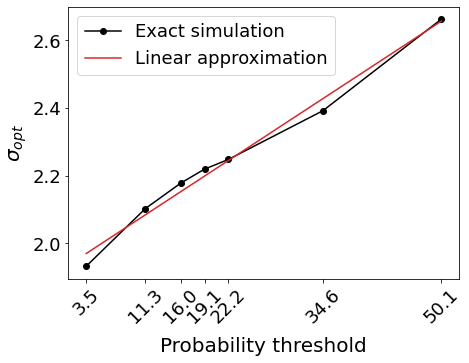

In [62]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(threshold, optimal_sigma, 'o-', color='black', label='Exact simulation')
ax.plot(threshold, a_opt*threshold+b_opt, color='tab:red', label='Linear approximation')

ax.set(ylabel=r'$\sigma_{{opt}}$', xticks=threshold)
ax.set_xlabel('Probability threshold', labelpad=10)
ax.set_xticklabels(threshold.round(1), rotation=45)
ax.legend()

plt.show()

##### Results: filtered events using optimal sigma for each threshold

In [2]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

optimal_sigma = util.load_pkl(data_path, 'optimal_sigma')
dilation_nb_sigmas = 2

threshold = util.load_pkl(data_path, 'mean_intensity_threshold')


for s, t in zip(optimal_sigma, threshold):
  print('\n\nSigma: %.1f | Threshold: %.1f'%(s, t))
  print('    Prepare stack...')
  proc_output_data, fission_props = preprocessing.prepareStack(output_data, sigma=s, dilation_nb_sigmas=dilation_nb_sigmas, threshold=t)
  print('    Segment fissions...')
  labels = preprocessing.segmentFissionsStack(output_data*segmentation.clear_border(output_data>0), fission_props, sigma=s/10)
  print('    Segment processed fissions...')
  proc_labels = preprocessing.segmentFissionsStack(proc_output_data, fission_props)
  print('    Analyze processed fissions...')
  proc_fission_props = preprocessing.analyzeFissionsStack(proc_labels, proc_output_data)
  
  util.save_h5(proc_output_data, data_path, 'WatProc_s%.1f_t%.1f'%(s, t))
  util.save_h5(labels, data_path, 'labels_s%.1f_t%.1f'%(s, t))
  util.save_h5(proc_labels, data_path, 'proc_labels_s%.1f_t%.1f'%(s, t))
  util.save_pkl(fission_props, data_path, 'fission_props_s%.1f_t%.1f'%(s, t))
  util.save_pkl(proc_fission_props, data_path, 'proc_fission_props_s%.1f_t%.1f'%(s, t))


Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/optimal_sigma

Loading H:/Santi/Data/mean_intensity_threshold


Sigma: 1.9 | Threshold: 3.5
    Prepare stack...


  0%|                                                          | 38/37000 [00:00<04:48, 127.93it/s]C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\preprocessing.py:110: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels = morphology.remove_small_objects(labels, 9) #Remove too small objects
100%|███████████████████████████████████████████████████████| 37000/37000 [03:14<00:00, 189.78it/s]


    Segment fissions...


100%|███████████████████████████████████████████████████████| 37000/37000 [00:50<00:00, 730.34it/s]


    Segment processed fissions...


100%|███████████████████████████████████████████████████████| 37000/37000 [00:44<00:00, 823.15it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:09<00:00, 3768.96it/s]



Saving H:/Santi/Data/WatProc_s1.9_t3.5.h5
Done.

Saving H:/Santi/Data/labels_s1.9_t3.5.h5
Done.

Saving H:/Santi/Data/proc_labels_s1.9_t3.5.h5
Done.

Saving H:/Santi/Data/fission_props_s1.9_t3.5
Done.

Saving H:/Santi/Data/proc_fission_props_s1.9_t3.5
Done.


Sigma: 2.1 | Threshold: 11.3
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [03:03<00:00, 202.03it/s]


    Segment fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:34<00:00, 1058.01it/s]


    Segment processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:30<00:00, 1205.52it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:06<00:00, 5656.22it/s]



Saving H:/Santi/Data/WatProc_s2.1_t11.3.h5
Done.

Saving H:/Santi/Data/labels_s2.1_t11.3.h5
Done.

Saving H:/Santi/Data/proc_labels_s2.1_t11.3.h5
Done.

Saving H:/Santi/Data/fission_props_s2.1_t11.3
Done.

Saving H:/Santi/Data/proc_fission_props_s2.1_t11.3
Done.


Sigma: 2.2 | Threshold: 16.0
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [02:57<00:00, 208.77it/s]


    Segment fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:28<00:00, 1308.22it/s]


    Segment processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:24<00:00, 1486.91it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:05<00:00, 6863.44it/s]



Saving H:/Santi/Data/WatProc_s2.2_t16.0.h5
Done.

Saving H:/Santi/Data/labels_s2.2_t16.0.h5
Done.

Saving H:/Santi/Data/proc_labels_s2.2_t16.0.h5
Done.

Saving H:/Santi/Data/fission_props_s2.2_t16.0
Done.

Saving H:/Santi/Data/proc_fission_props_s2.2_t16.0
Done.


Sigma: 2.2 | Threshold: 19.1
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [02:54<00:00, 211.69it/s]


    Segment fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:24<00:00, 1510.37it/s]


    Segment processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:21<00:00, 1698.07it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:04<00:00, 7988.22it/s]



Saving H:/Santi/Data/WatProc_s2.2_t19.1.h5
Done.

Saving H:/Santi/Data/labels_s2.2_t19.1.h5
Done.

Saving H:/Santi/Data/proc_labels_s2.2_t19.1.h5
Done.

Saving H:/Santi/Data/fission_props_s2.2_t19.1
Done.

Saving H:/Santi/Data/proc_fission_props_s2.2_t19.1
Done.


Sigma: 2.2 | Threshold: 22.2
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [02:50<00:00, 217.55it/s]


    Segment fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:21<00:00, 1717.99it/s]


    Segment processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:18<00:00, 1959.57it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:04<00:00, 9156.84it/s]



Saving H:/Santi/Data/WatProc_s2.2_t22.2.h5
Done.

Saving H:/Santi/Data/labels_s2.2_t22.2.h5
Done.

Saving H:/Santi/Data/proc_labels_s2.2_t22.2.h5
Done.

Saving H:/Santi/Data/fission_props_s2.2_t22.2
Done.

Saving H:/Santi/Data/proc_fission_props_s2.2_t22.2
Done.


Sigma: 2.4 | Threshold: 34.6
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [02:38<00:00, 233.11it/s]


    Segment fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:08<00:00, 4573.86it/s]


    Segment processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:07<00:00, 5113.39it/s]


    Analyze processed fissions...


100%|█████████████████████████████████████████████████████| 37000/37000 [00:01<00:00, 18914.06it/s]



Saving H:/Santi/Data/WatProc_s2.4_t34.6.h5
Done.

Saving H:/Santi/Data/labels_s2.4_t34.6.h5
Done.

Saving H:/Santi/Data/proc_labels_s2.4_t34.6.h5
Done.

Saving H:/Santi/Data/fission_props_s2.4_t34.6
Done.

Saving H:/Santi/Data/proc_fission_props_s2.4_t34.6
Done.


Sigma: 2.7 | Threshold: 50.1
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [02:28<00:00, 249.29it/s]


    Segment fissions...


100%|█████████████████████████████████████████████████████| 37000/37000 [00:00<00:00, 41522.33it/s]


    Segment processed fissions...


100%|█████████████████████████████████████████████████████| 37000/37000 [00:00<00:00, 45194.74it/s]


    Analyze processed fissions...


100%|█████████████████████████████████████████████████████| 37000/37000 [00:00<00:00, 42123.84it/s]



Saving H:/Santi/Data/WatProc_s2.7_t50.1.h5
Done.

Saving H:/Santi/Data/labels_s2.7_t50.1.h5
Done.

Saving H:/Santi/Data/proc_labels_s2.7_t50.1.h5
Done.

Saving H:/Santi/Data/fission_props_s2.7_t50.1
Done.

Saving H:/Santi/Data/proc_fission_props_s2.7_t50.1
Done.


### Temporal median filter

Removing events that are not probably fissions doesn't use all the information we know about this process. One main aspect that was not considered before is that mitochondrial divisions last for a certain period of time. Therefore, the temporal binary signal that results from classifying frames as 'active' or 'inactive' shouldn't include short peaks ore noise. Here we show that a underestimating this factor introduces noise and how to fix it with a temporal median filter.

In [2]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs-
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

output_data = preprocessing.prepareStack(output_data, sigma=2, mode='mean')[0]


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


  0%|                                                          | 35/37000 [00:00<05:25, 113.46it/s]C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\preprocessing.py:114: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels = morphology.remove_small_objects(labels, 9) #Remove too small objects
100%|███████████████████████████████████████████████████████| 37000/37000 [03:35<00:00, 171.98it/s]


In [34]:
division_mask = output_data!=0
binary_output = (np.any(np.any(division_mask, axis=1), axis=1))

#Active/inactive percentages in binary_output
print('Active: %.2f%%\nInactive: %.2f%%'%util.activity_percent(binary_output))

Active: 61.66%
Inactive: 38.34%


In [61]:
nb_img = output_data.shape[0]
mean_output_data = np.zeros(nb_img)
for frame in tqdm(np.where(binary_output)[0]):
  mean_output_data[frame] = np.mean(output_data[frame])

#Automatic thresholding with Otsu's method
mean_output_threshold = filters.threshold_multiotsu(mean_output_data)[1] #Keep frames with high probability of division
binary_peaks = mean_output_data>mean_output_threshold

100%|█████████████████████████████████████████████████████| 22816/22816 [00:00<00:00, 23099.63it/s]


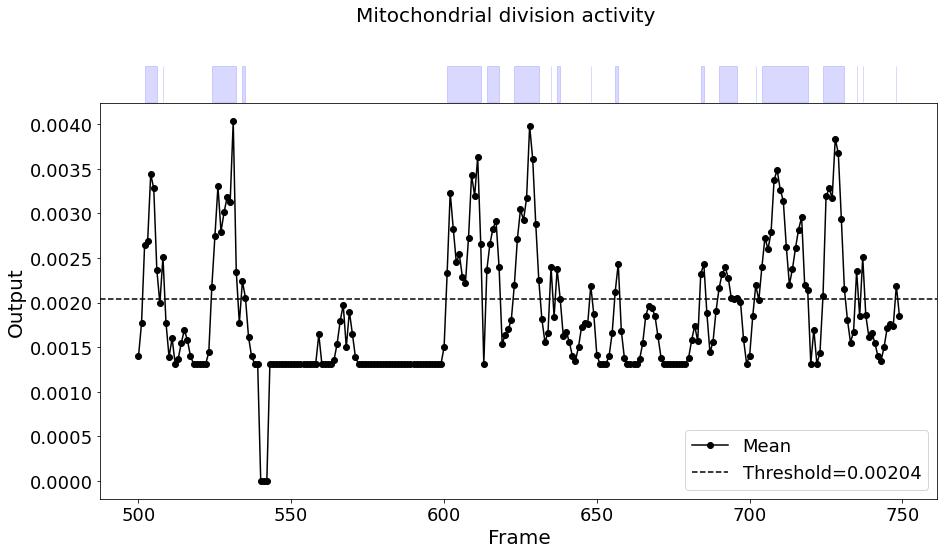

In [62]:
frames = np.arange(500, 750)
legend_loc = 'lower right'

fig = plt.figure(figsize=(15,8))
fig.suptitle('Mitochondrial division activity', size=20)

gs = fig.add_gridspec(2, 1, height_ratios=[1, 10], hspace=0)
ax_mean = fig.add_subplot(gs[1])
ax_binary = fig.add_subplot(gs[0], sharex=ax_mean)

#GT mean signal and temporal median filtering
ax_mean.plot(frames, mean_output_data[frames], 'o-', color='black', label='Mean')
ax_mean.axhline(mean_output_threshold, ls='--', color='black', label='Threshold=%.5f'%mean_output_threshold)
ax_mean.set(xlabel='Frame', ylabel='Output')
ax_mean.legend(loc=legend_loc)

#Derived mitochondrial division activity by thresholding
ax_binary.fill_between(frames, 0, 1, where=binary_peaks[frames], color='blue', alpha=0.15)

ax_binary.axis('off')  

plt.show()

To filter the noise in the signal, we apply a temporal median filter. Then we perform Otsu thresholding on the filtered mean output.

In [63]:
window_size = 5
filtered_mean_output = ndi.median_filter(mean_output_data, size=window_size)
mean_output_threshold = filters.threshold_multiotsu(filtered_mean_output)[1]

print('Threshold: %f'%mean_output_threshold)
binary_peaks = mean_output_data>mean_output_threshold
filtered_binary_peaks = filtered_mean_output>mean_output_threshold

util.save_pkl(filtered_binary_peaks, data_path, 'temporal_filter')

#Active/inactive percentages in filtered_binary_output
print('\nWithout temporal median filter')
print('Active: %.2f%%\nInactive: %.2f%%'%util.activity_percent(binary_output))
print('\nWith temporal median filter')
print('Active: %.2f%%\nInactive: %.2f%%'%util.activity_percent(filtered_binary_output))

Threshold: 0.001989

Saving H:/Santi/Data/temporal_filter
Done.

Without temporal median filter
Active: 61.66%
Inactive: 38.34%

With temporal median filter
Active: 13.72%
Inactive: 86.28%


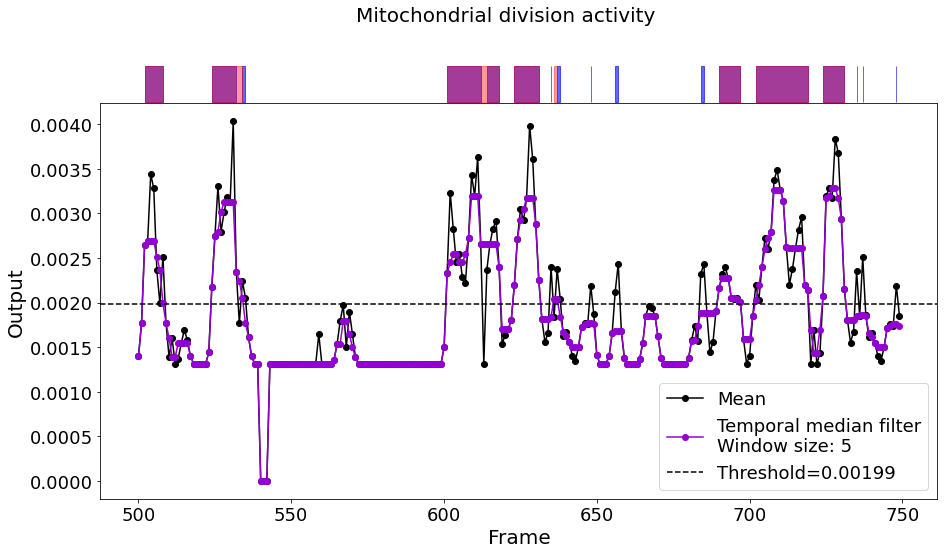

In [64]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Mitochondrial division activity', size=20)

gs = fig.add_gridspec(2, 1, height_ratios=[1, 10], hspace=0)
ax_mean = fig.add_subplot(gs[1])
ax_binary = fig.add_subplot(gs[0], sharex=ax_mean)

#GT mean signal and temporal median filtering
ax_mean.plot(frames, mean_output_data[frames], 'o-', color='black', label='Mean')
ax_mean.plot(frames, filtered_mean_output[frames], 'o-', color='darkviolet', label='Temporal median filter\nWindow size: %i'%window_size)
ax_mean.axhline(mean_output_threshold, ls='--', color='black', label='Threshold=%.5f'%mean_output_threshold)
ax_mean.set(xlabel='Frame', ylabel='Output')
ax_mean.legend(loc=legend_loc)

#Derived mitochondrial division activity by thresholding

ax_binary.fill_between(frames, 0, 1, where=binary_peaks[frames], color='blue', alpha=0.6)
ax_binary.fill_between(frames, 0, 1, where=filtered_binary_peaks[frames], color='red', alpha=0.4)

ax_binary.axis('off')
plt.show()

To determine if the removed positives were noise, we analyzed the mean duration of the removed sequences of frames. If the removed frames doesn't correspond to divisions, their maximum duration should not be longer than a few frames. In this case, we see that the maximum duration is 2 frames:

In [65]:
filtered_positives = binary_peaks & ~filtered_binary_peaks
percent_filtered_positives = 100*(filtered_positives).sum()/(binary_peaks.sum())
#Mean duration of filtered positives
max_duration = util.sequence_length(filtered_positives).max()  
print('Positives removed by temporal median filter: %.2f%%'%percent_filtered_positives)
print('Max duration of removed positives: %i frames'%max_duration)

Positives removed by temporal median filter: 14.87%
Max duration of removed positives: 2 frames


#### Visualization of pixels that were turned off (Active -> Inactive) and on (Inactive -> Active) because of the temporal median filter

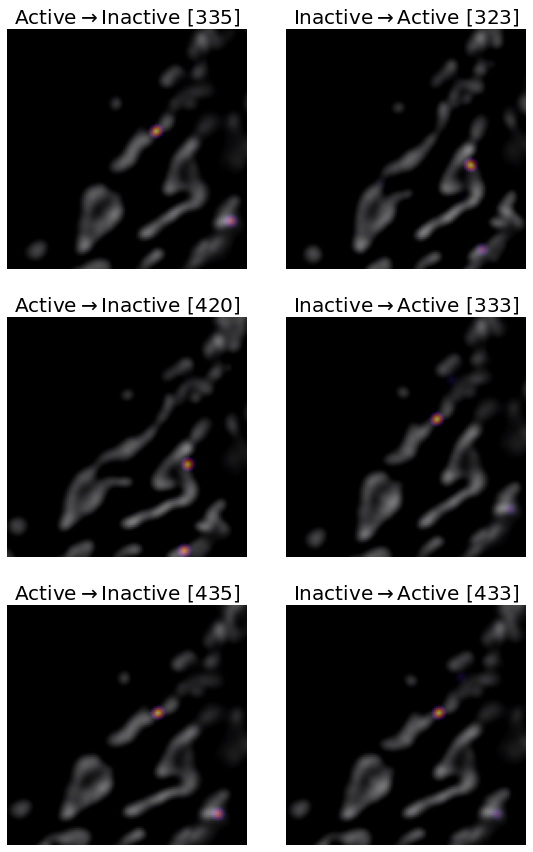

In [42]:
nb_frames = 3
item_id_active = frames[np.where(~binary_peaks[frames] & filtered_binary_peaks[frames])[0][:nb_frames ]]
item_id_inactive = frames[np.where(binary_peaks[frames] & ~filtered_binary_peaks[frames])[0][:nb_frames ]]
fig, axes = plt.subplots(nb_frames, 2, figsize=(5*2, 5*nb_frames))

for frame_active, frame_inactive, ax in zip(item_id_active, item_id_inactive, axes):
  plotting.plot_merge(input_data[frame_inactive], output_data[frame_inactive], ax=ax[0], title='Active'+r'$\rightarrow$'+'Inactive', frame=frame_inactive)
  plotting.plot_merge(input_data[frame_active], output_data[frame_active], ax=ax[1], title='Inactive'+r'$\rightarrow$'+'Active', frame=frame_active)
  
fig.subplots_adjust(wspace=0)

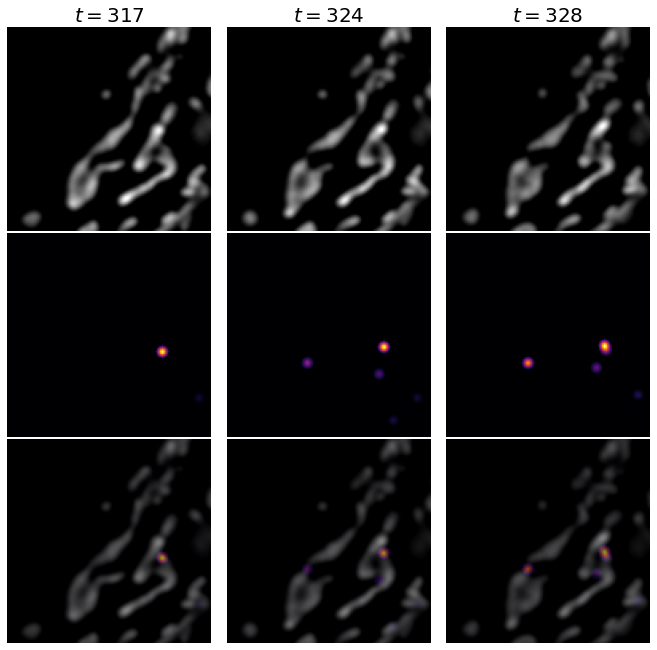

In [43]:
nb_examples = 3
item_id = [317, 324, 328]
size = nb_examples*3
fig, axes = plt.subplots(nb_examples, nb_examples, figsize=(size, size))
for i, frame in enumerate(item_id):
  plotting.plot_comparison(input_data[frame], output_data[frame], merge=True, axes=axes[:, i])
  axes[0, i].set_title('$t=%i$'%frame, size=20)
  axes[1, i].set_title('')
  axes[2, i].set_title('')

fig.subplots_adjust(left=0, right=1, top=0.96, bottom=0.01, wspace=0.05, hspace=0.01)
plt.show()
#fig.savefig(new_data_path+'division_example.pdf')

#### How to choose the window size

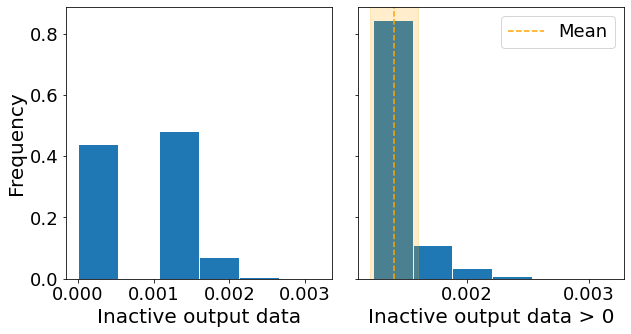

In [44]:
inactive_output_data = filtered_mean_output[binary_peaks==False]
nonzero_inactive_output_data = filtered_mean_output[(binary_peaks==False)&(filtered_mean_output>0)]

nbins = 7

xlabel=['Inactive output data', 'Inactive output data > 0']
ylabel=['Frequency', None]
fig, axes = plt.subplots(1, 2, figsize=(5*2, 5), sharey=True)

for inactive_data, xlab, ylab, ax in zip([inactive_output_data, nonzero_inactive_output_data], xlabel, ylabel, axes):
  inactive_output_bins = np.linspace(inactive_data.min(), inactive_data.max(), nbins, endpoint=True)
  inactive_output_bincenters, inactive_output_hist = util.norm_histogram(inactive_output_bins, inactive_data)[:2]
  binwidth= np.diff(inactive_output_bins)
  plotting.plot_histogram(inactive_output_bincenters, binwidth*inactive_output_hist, xlabel=xlab, ylabel=ylab, ax=ax)

inactive_mean, inactive_std = nonzero_inactive_output_data.mean(), nonzero_inactive_output_data.std()
axes[1].axvline(inactive_mean, ls='--', color='orange', label='Mean')
axes[1].axvspan(inactive_mean-inactive_std, inactive_mean+inactive_std, color='orange', alpha=0.2, label='')
axes[1].legend(loc='upper right')
plt.subplots_adjust(wspace=0.1)
plt.show()

In [51]:
window_size = np.arange(2, 100)
nonzero_inactivity_mean = np.zeros(window_size.shape)
nonzero_inactivity_std = np.zeros(window_size.shape)

for i, size in enumerate(window_size):
  filtered_mean_output = ndi.median_filter(mean_output_data, size=size)
  mean_output_threshold = filters.threshold_multiotsu(filtered_mean_output)[1]
  
  nonzero_inactive_output_data = filtered_mean_output[(mean_output_data==0)&(filtered_mean_output>0)]
  nonzero_inactivity_std[i] = nonzero_inactive_output_data.std()
  nonzero_inactivity_mean[i] = nonzero_inactive_output_data.mean()
  
nonzero_inactivity_mean = (nonzero_inactivity_mean-nonzero_inactivity_mean.min())/(nonzero_inactivity_mean.max()- nonzero_inactivity_mean.min())
nonzero_inactivity_std = (nonzero_inactivity_std-nonzero_inactivity_std.min())/(nonzero_inactivity_std.max()- nonzero_inactivity_std.min())

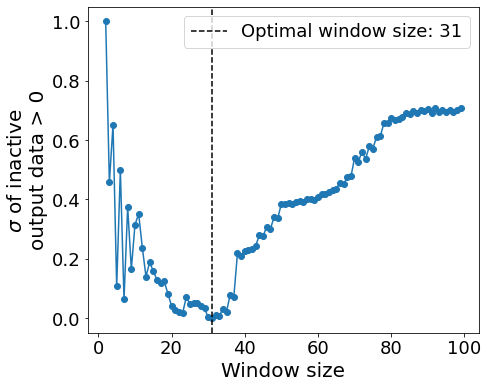

In [52]:
metric = nonzero_inactivity_std
optimal_id = metric==metric.min()
optimal_window_size = window_size[optimal_id][0]
fig, ax = plt.subplots(figsize=(7, 6), sharex=True)
ax.plot(window_size, metric, 'o-')
ax.set(xlabel='Window size', ylabel='$\sigma$ of inactive\noutput data > 0')
ax.axvline(optimal_window_size, ls='--', color='black', label='Optimal window size: %i'%optimal_window_size)
ax.legend()
fig.subplots_adjust(wspace=0.4)

plt.show()

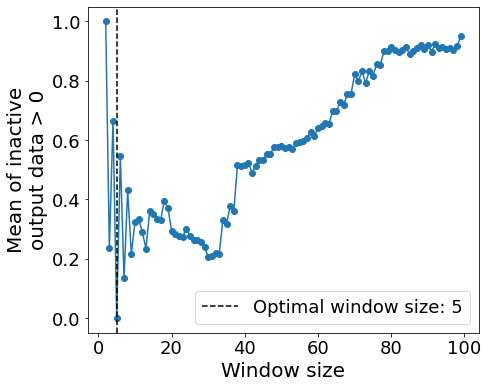

In [53]:
metric = nonzero_inactivity_mean
optimal_id = metric==metric.min()
optimal_window_size = window_size[optimal_id][0]
fig, ax = plt.subplots(figsize=(7, 6), sharex=True)
ax.plot(window_size, metric, 'o-')
ax.set(xlabel='Window size', ylabel='Mean of inactive\noutput data > 0')
ax.axvline(optimal_window_size, ls='--', color='black', label='Optimal window size: %i'%optimal_window_size)
ax.legend()
fig.subplots_adjust(wspace=0.4)

plt.show()